In [1]:
import pandas as pd

# Membaca file CSV yang diunggah
file_path = 'pollutant-standards-index-jogja-2020.csv'
data = pd.read_csv(file_path)

# Menampilkan beberapa baris pertama dari data untuk eksplorasi awal
data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Date                366 non-null    object
 1   PM10                366 non-null    int64 
 2   SO2                 366 non-null    int64 
 3   CO                  366 non-null    int64 
 4   O3                  366 non-null    int64 
 5   NO2                 366 non-null    int64 
 6   Max                 366 non-null    int64 
 7   Critical Component  366 non-null    object
 8   Category            366 non-null    object
dtypes: int64(6), object(3)
memory usage: 25.9+ KB


(       Date  PM10  SO2  CO  O3  NO2  Max Critical Component  Category
 0  1/1/2020    30    2  69  19    0   69                 CO  Moderate
 1  1/2/2020    16    2  58  33    0   58                 CO  Moderate
 2  1/3/2020    12    2  46  18    0   46                 CO      Good
 3  1/4/2020     8    2  84  29    0   84                 CO  Moderate
 4  1/5/2020     8    3  50   0    0   50                 CO      Good,
 None)

In [2]:
from sklearn.preprocessing import LabelEncoder

# Mengubah kategori menjadi label numerik
label_encoder = LabelEncoder()
data['Category_Label'] = label_encoder.fit_transform(data['Category'])

# Menyiapkan fitur dan target
features = data[['PM10', 'SO2', 'CO', 'O3', 'NO2']]
target = data['Category_Label']

# Menampilkan label encoding untuk kategori
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
features.head(), target.head(), label_mapping

(   PM10  SO2  CO  O3  NO2
 0    30    2  69  19    0
 1    16    2  58  33    0
 2    12    2  46  18    0
 3     8    2  84  29    0
 4     8    3  50   0    0,
 0    1
 1    1
 2    0
 3    1
 4    0
 Name: Category_Label, dtype: int64,
 {'Good': 0, 'Moderate': 1, 'Unhealthy': 2})

In [3]:
from sklearn.model_selection import train_test_split

# Membagi data menjadi set pelatihan (80%) dan pengujian (20%)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

# Menampilkan ukuran data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((292, 5), (74, 5), (292,), (74,))

In [4]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# 1. Implementasi ELMClassifier
class ELMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_layer_size=100, activation_function='sigmoid', random_state=None):
        self.hidden_layer_size = hidden_layer_size
        self.activation_function = activation_function
        self.random_state = random_state

    def _activation(self, X):
        if self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-X))
        elif self.activation_function == 'tanh':
            return np.tanh(X)
        elif self.activation_function == 'relu':
            return np.maximum(0, X)
        else:
            raise ValueError("Unsupported activation function.")

    def fit(self, X, y):
        np.random.seed(self.random_state)

        # One-hot encoding untuk target label
        y_encoded = np.zeros((y.size, y.max() + 1))
        y_encoded[np.arange(y.size), y] = 1

        # Inisialisasi bobot input dan bias secara acak
        self.input_weights = np.random.randn(X.shape[1], self.hidden_layer_size)
        self.biases = np.random.randn(1, self.hidden_layer_size)

        # Hitung output dari lapisan tersembunyi
        H = self._activation(np.dot(X, self.input_weights) + self.biases)

        # Hitung bobot output menggunakan pseudoinverse Moore-Penrose
        self.output_weights = np.linalg.pinv(H).dot(y_encoded)
        return self

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        output = H.dot(self.output_weights)
        return np.argmax(output, axis=1)




In [5]:
# 2. Persiapan Data
# Misalkan Anda sudah memiliki X_train dan y_train, dan dataset memiliki label kategori seperti 'Good', 'Moderate', 'Unhealthy'

# Menyusun LabelEncoder untuk mengonversi label kategorikal ke angka
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Encode y_train ke dalam bentuk numerik
y_test_encoded = label_encoder.transform(y_test)  # Encode y_test menggunakan label yang sama

In [7]:
from sklearn.metrics import mean_squared_error

# 3. Melatih Model ELM
elm_model = ELMClassifier(hidden_layer_size=100, activation_function='relu', random_state=42)
elm_model.fit(X_train.values, y_train_encoded)

# 4. Memprediksi Data Uji
y_pred = elm_model.predict(X_test.values)

# Konversi y_test menjadi one-hot encoding agar konsisten dengan format keluaran ELM
y_test_one_hot = np.zeros((y_test_encoded.size, y_test_encoded.max() + 1))
y_test_one_hot[np.arange(y_test_encoded.size), y_test_encoded] = 1

# Hitung output dari lapisan tersembunyi untuk data uji
H_test = elm_model._activation(np.dot(X_test.values, elm_model.input_weights) + elm_model.biases)

# Hitung hasil prediksi akhir (sebelum argmax) menggunakan bobot output
y_pred_raw = H_test.dot(elm_model.output_weights)

# Hitung Mean Squared Error (MSE)
mse = mean_squared_error(y_test_one_hot, y_pred_raw)

# 5. Mengembalikan Hasil Prediksi ke Kategori Asli
y_pred_labels = label_encoder.inverse_transform(y_pred)  # Mengonversi hasil prediksi menjadi kategori asli

# 6. Menyusun Akurasi
accuracy = accuracy_score(y_test, y_pred_labels)
print("Akurasi Model pada Data Uji: ", accuracy)
print("Mean Squared Error (MSE) of the model:", mse)

Akurasi Model pada Data Uji:  0.9054054054054054
Mean Squared Error (MSE) of the model: 0.05375463131022339


In [10]:
import pandas as pd
import numpy as np

# Misalkan 'features' adalah DataFrame yang berisi fitur asli Anda
# Membuat data sintetis berdasarkan rentang data asli
min_values = features.min().values
max_values = features.max().values
adjusted_max_values = np.where(min_values >= max_values, min_values + 1, max_values)

data_sintetis = np.random.randint(low=min_values, high=adjusted_max_values, size=(20, features.shape[1]))

# Mengonversi data sintetis ke DataFrame dan menambahkan nama kolom
data_sintetis_df = pd.DataFrame(data_sintetis, columns=features.columns)

# Memprediksi kategori untuk data sintetis
prediksi_sintetis = elm_model.predict(data_sintetis_df)
hasil_kategori = label_encoder.inverse_transform(prediksi_sintetis)

# Menambahkan kolom Predicted_Category ke DataFrame
data_sintetis_df['Predicted_Category'] = hasil_kategori

# Menampilkan DataFrame dan kolom
print(data_sintetis_df.head(10))
print("\nNama Kolom:")
print(data_sintetis_df.columns)

   PM10  SO2   CO  O3  NO2  Predicted_Category
0    35    3    7  33    0                   0
1    37    5   31  45    0                   0
2    45    3  141  54    0                   1
3    50    1    6  73    0                   1
4     9    0  150  18    0                   2
5    50    4  146  35    0                   1
6    31    3   81   1    0                   1
7     3    4  147  10    0                   2
8    44    1  118  11    0                   1
9    22    4   36  37    0                   0

Nama Kolom:
Index(['PM10', 'SO2', 'CO', 'O3', 'NO2', 'Predicted_Category'], dtype='object')


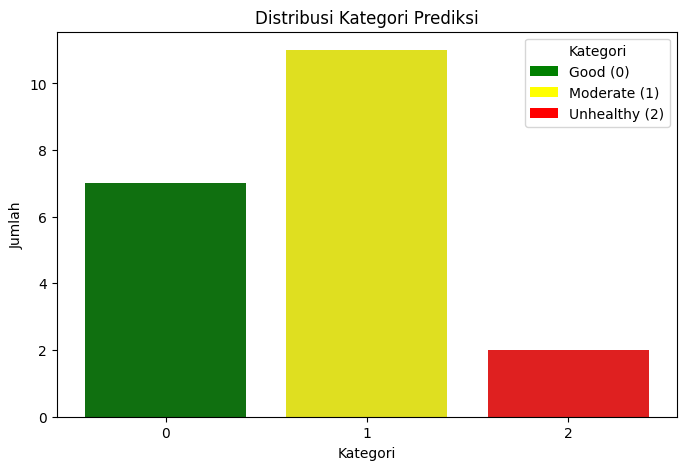

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Warna untuk kategori
palette = {'0': 'green', '1': 'yellow', '2': 'red'}

# Ubah kolom 'Predicted_Category' menjadi string (jika belum)
data_sintetis_df['Predicted_Category'] = data_sintetis_df['Predicted_Category'].astype(str)

# Plot distribusi hasil prediksi kategori
plt.figure(figsize=(8, 5))
sns.countplot(
    x='Predicted_Category',
    hue='Predicted_Category',  # Assign hue to the same column
    data=data_sintetis_df,
    palette=palette,
    dodge=False,  # Prevent separation of bars for hue
    legend=False  # Turn off default legend
)

# Tambahkan legenda dengan deskripsi
legend_labels = ['Good (0)', 'Moderate (1)', 'Unhealthy (2)']
for category, color in palette.items():
    plt.bar(0, 0, color=color, label=legend_labels[int(category)])  # Dummy bars for legend

plt.title("Distribusi Kategori Prediksi")
plt.xlabel("Kategori")
plt.ylabel("Jumlah")
plt.legend(title="Kategori", loc='upper right')
plt.show()


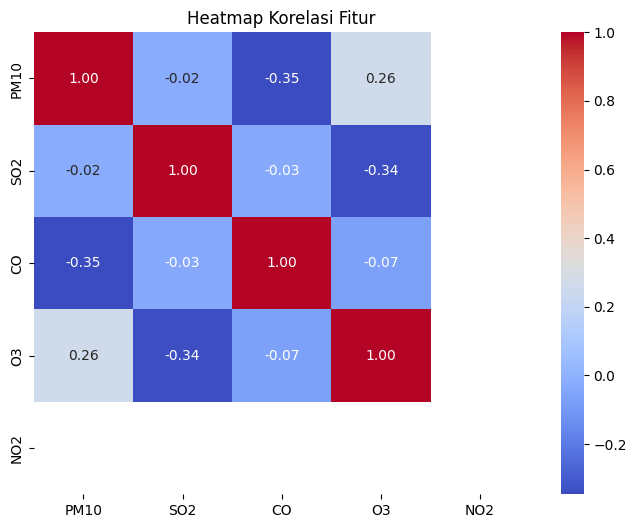

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Korelasi antara fitur
correlation_matrix = data_sintetis_df[features.columns].corr()

# Membuat heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap Korelasi Fitur")
plt.show()
